# Churchland Widefield Data

This notebook demonstrates:
- Decoding L/R choice from different periods of the delay period

In [1]:
#Import Statements
import numpy as np
import pandas as pd
import ssm
import re
import seaborn as sns
import numpy.random as npr
import matplotlib.pyplot as plt
import numpy.linalg as la
from collections import OrderedDict
from matplotlib.font_manager import FontProperties
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from ssm import LDS
from Session import *
from ChoicePredictor import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
from matplotlib.cm import get_cmap
cmap = get_cmap('coolwarm')

# Single Session

## 0. Specify the mouse and session date you are looking at

In [3]:
mouse = "mSM36"
day = "05-Dec-2017"

## 1A. Load relevant classes

In [4]:
session = Session("vistrained", mouse, day)
predictor = SVCChoice(session, "behavenet")

## 1B. Fit polynomial-kernel SVC over each time step

In [5]:
results = predictor.fit_all()

In [6]:
# Save the logistic regression models
pickle.dump(results, open(
    "pickles/choicedecoding_behavelatents_" + mouse + "_" + day + ".p", "wb"
    ))

## 2. Plot decoding accuracy over time

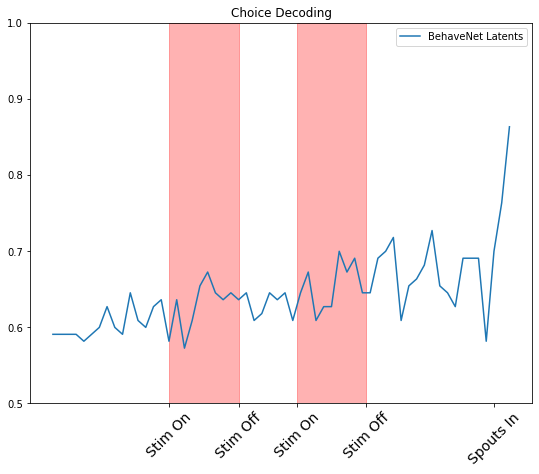

In [7]:
# Plot decoding accuracy over time
start_frame = []
accuracy = []
plt.figure(figsize=(9,7))
for frame, score in enumerate(results['scores']):
    start_frame.append(frame*2)
    accuracy.append(score)
plt.xticks(
    ticks=[30, 30+18, 30+33, 30+51, 30+84],
    labels=['Stim On', 'Stim Off', 'Stim On', 'Stim Off', 'Spouts In'],
    rotation=45, fontsize=14
    )
plt.axvspan(30, 30+18, alpha=0.3, color='red')
plt.axvspan(30+33, 30+51, alpha=0.3, color='red')
plt.title("Choice Decoding")
plt.ylim((0.5,1))
sns.lineplot(
    x=start_frame, y=accuracy, label="BehaveNet Latents",
    linewidth=1.5
    )

# All Sessions

## 1. Fit LR models for all sessions

In [ ]:
task = "vistrained"
taskdir = "/home/chingf/engram/data/musall/" + task + "/"
analysisdir = "/home/chingf/engram/analysis/behavenet/musall/" + task + "/"

In [ ]:
# Run logistic regression over all available sessions
all_results = {}
all_accuracy = []
for mouse in os.listdir(taskdir):
    if not mouse.startswith("mSM"):
        continue
    if not mouse in os.listdir(analysisdir):
        continue
    mousedir = taskdir + mouse + "/"
    for day in os.listdir(mousedir):
        if not re.match("\d{2}-\w+-\d{4}", day):
            print("Invalid directory: " + day)
            continue
        if not day in os.listdir(analysisdir + animal + "/"):
            continue
        session = Session("vistrained", mouse, day)
        predictor = SVCChoice(session, "behavenet")
        results = predictor.fit_all()
        # Save the logistic regression models
        pickle.dump(results, open(
            "pickles/choicedecoding_behavelatents_" + mouse + "_" + day + ".p", "wb"
            ))

## 2. Decoding: Which time periods are most predictive?

In [ ]:
# If already available, load the logistic regression models
with open("temporaldecoding_behavenet_all.p", "rb") as f:
    all_results = pickle.load(f)

In [ ]:
# Collect and plot the 'accuracy grid' of each session
all_accuracy = []
for k1 in all_results.keys():
    for k2 in all_results[k1].keys():
        results = all_results[k1][k2]
        # Collect the cross-validated accuracy
        accuracy_grid = []
        for idx, window_length in enumerate(window_lengths):
            window_results = results[idx]
            window_accuracy = []
            for r in window_results:
                if r == None:
                    window_accuracy.append(0)#np.isnan)
                    continue
                score = np.max(np.mean(r.scores_[1], axis=0))
                window_accuracy.append(score)
            accuracy_grid.append(window_accuracy)
        accuracy_grid = np.array(accuracy_grid)
        all_accuracy.append(accuracy_grid)
        
#         # Plot the cross-validated accuracy
#         plt.figure(figsize=(10,8))
#         plt.imshow(accuracy_grid, cmap=cmap, aspect='auto', clim=(0.5, 1))
#         plt.colorbar()
#         plt.xlabel("Start Frame")
#         plt.ylabel("Framesize of Window")
#         plt.yticks(
#             ticks=np.arange(len(window_lengths)),
#             labels=[1*w for w in window_lengths]
#             )
#         plt.xticks(
#             ticks=np.arange(1, accuracy_grid.shape[1], 10),
#             labels=np.arange(1, accuracy_grid.shape[1], 10)
#             )
#         plt.title("Logistic Regression Accuracy\n" + k1 + "    " + k2)
#         plt.show()

        # Visualize accuracy just for window lengths of 2
        plt.figure()
        accuracy = []
        start_frame = []
        for idx, val in enumerate(accuracy_grid[0,:]):
            if val == 0:
                continue
            accuracy.append(val)
            start_frame.append(idx)
        plt.plot(start_frame, accuracy)
        plt.title("Decoding with window length of 2 frames\n" + k1 + "    " + k2)
        plt.ylabel("Choice Decoding Accuracy")
        plt.xlabel("Start Frame")
        plt.show()

In [ ]:
# Get the mean accuracy grid
mean_accuracy = np.zeros((len(window_lengths), 120))
accuracy_counts = np.zeros(mean_accuracy.shape)
for accuracy in all_accuracy:
    for i in range(accuracy.shape[0]):
        for j in range(120):
            mean_accuracy[i][j] += accuracy[i][j]
            accuracy_counts[i][j] += 1

mean_accuracy = np.divide(mean_accuracy, accuracy_counts)

In [ ]:
# Plot the cross-validated accuracy
plt.figure(figsize=(10,8))
plt.imshow(mean_accuracy, cmap=cmap, aspect='auto', clim=(0.5, 1))
plt.colorbar()
plt.xlabel("Start Frame")
plt.ylabel("Framesize of Window")
plt.yticks(
    ticks=np.arange(len(window_lengths)),
    labels=[1*w for w in window_lengths]
    )
plt.title("Logistic Regression Accuracy\nAveraged over all Sessions\n")
plt.show()

## 3. Decoding: Which regions are most predictive over time?

In [ ]:
# Visualize accuracy just for window lengths of 2

# Get all the window length 2 accuracies
accuracy_vals = []
start_frames = []
for accuracy in all_accuracy:
    for i in range(accuracy.shape[0]):
        for j in range(120):
            if accuracy[i][j] == 0:
                continue
            accuracy_vals.append(accuracy[i][j])
            start_frames.append(j)
df = pd.DataFrame({
    'Accuracy': accuracy_vals,
    'Frame': start_frames
    })

plt.figure(figsize=(9,7))
ax = sns.lineplot(x="Frame", y="Accuracy", data=df)
plt.title("Decoding with window length of 2 frames\n(All Sessions)", fontsize=14)
plt.ylabel("Choice Decoding Accuracy", fontsize=14)
plt.xlabel("Start Frame")
plt.xticks(
    ticks=[30, 30+18, 30+33, 30+51, 30+84],
    labels=['Stim On', 'Stim Off', 'Stim On', 'Stim Off', 'Spouts In'],
    rotation=45, fontsize=14
    )
ax.axvspan(30, 30+18, alpha=0.3, color='red')
ax.axvspan(30+33, 30+51, alpha=0.3, color='red')
plt.ylim((0.5,1))
plt.show()